# 임포트 부분

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Input, GlobalMaxPool1D, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import re

import tensorflow as tf
from konlpy.tag import Okt
from tqdm import trange, notebook

# 데이터가져오기

In [110]:
a = pd.read_excel('total_최종.xlsx')
a

,data,label
0,Game Designer(게임 디자이너)\n\n비디오 게임 제작자의 부류. 영어로는...,game
1,"게임크리에이터, 게임디자이너\n게임기획자는 PC 게임, 네트워크 게임 등 게임용 소...",game
2,"게임기획자란?\n실제 게임제작, 게임프로그래밍이나 그래픽 작업에 들어가기 전 어떤 ...",game
3,"하는일\n컴퓨터 게임의 아이템과 스토리, 캐릭터 등을 구성 및 기획하고 제작 과정을...",game
4,게임기획자\n\n게임 기획자는 게임 회사의 기획팀에 속해서 일하는 사람들을 말합니다...,game
...,...,...
118,안녕하세요. 자기소개 부탁드립니다.\n안녕하세요! 개발자 고영정이라고 합니다. 토스...,mobile
119,버즈빌에 대한 간단한 소개도 부탁드립니다.\n버즈빌은 글로벌 잠금 화면 광고 플랫폼...,mobile
120,반갑습니다. 자기소개 부탁 드립니다.\n안녕하세요. 캐시슬라이드에서 제품길드의 클라...,mobile
121,안녕하세요. 간단한 자기소개 부탁 드립니다.\n안녕하세요! 와이즈솔루션 테크니컬 파...,mobile


# 특수문자 제거

In [111]:
a['data'] = a['data'].str.replace("[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9 ]","")
a

<ipython-input-111-f18787e8bf6f>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  a['data'] = a['data'].str.replace("[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9 ]","")


,data,label
0,Game Designer게임 디자이너비디오 게임 제작자의 부류 영어로는 게임 디자이...,game
1,게임크리에이터 게임디자이너게임기획자는 PC 게임 네트워크 게임 등 게임용 소프트웨어...,game
2,게임기획자란실제 게임제작 게임프로그래밍이나 그래픽 작업에 들어가기 전 어떤 게임을 ...,game
3,하는일컴퓨터 게임의 아이템과 스토리 캐릭터 등을 구성 및 기획하고 제작 과정을 관리...,game
4,게임기획자게임 기획자는 게임 회사의 기획팀에 속해서 일하는 사람들을 말합니다 보통 ...,game
...,...,...
118,안녕하세요 자기소개 부탁드립니다안녕하세요 개발자 고영정이라고 합니다 토스랩은 잔디라...,mobile
119,버즈빌에 대한 간단한 소개도 부탁드립니다버즈빌은 글로벌 잠금 화면 광고 플랫폼을 만...,mobile
120,반갑습니다 자기소개 부탁 드립니다안녕하세요 캐시슬라이드에서 제품길드의 클라이언트 클...,mobile
121,안녕하세요 간단한 자기소개 부탁 드립니다안녕하세요 와이즈솔루션 테크니컬 파트에서 일...,mobile


# 형태소 분석, 불용어 제거

In [112]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','으로','자','에','와','한','하다','을', '를', '이', '가', '은', '는','이','그','있','n','nn','t','의','되','라','한','다','하','더','에','서','나',
            '과','고','며','와','지','해','도','지','못','안','않','로','들','된','것','에는','안녕','반갑','내','등','할','자','있다','','직','군','위','식','각','출','창','시','수','및','신','영','화','살','여','양','송','대','데',
            '연','구','살','장','또','적','D','력','인','향','년','후','생','기','봐','문','니','사','본','제','작','관','일','분','야','중','거','명','어','개','타','제','또는','요','전','몇','중','에서','있는데요','된다','또한','되','돼','않','으로','만','있습니다','하는','하는것이',
            '만','푹','지금','하는','곳','있다','되다','만들다', '대한', '어떻다', '보다', '때문', '같다', '필요하다','관련','사용','않다', '에는',
            '지식','이나','되어다','아니다','없다','위해','가장','고','다양하다', '팀', '담당', '전', '만',
            '더', '요','또한','받다','갖추다','내', '따르다', '그렇다', '자다','게','정도', '좋다', '이다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()
tokenized_data = []

for sentence in notebook.tqdm(b['data']):  # 프로그레스 바
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    #temp_X = [word for word in temp_X if len(word) > 1] # 한글자는 제거
    tokenized_data.append(temp_X)

  0%|          | 0/123 [00:00<?, ?it/s]

# array 변환

In [113]:
x = np.array(tokenized_data)
y = a.label.values

<ipython-input-113-609f2ddec93a>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = np.array(tokenized_data)


# y라벨 변환

In [89]:
le = LabelEncoder()
y = le.fit_transform(y)
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]


# 라벨 원핫인코딩

In [90]:
y_cat = to_categorical(y)
print(y_cat)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0.

# 트레인 테스트 나누기

In [91]:
x_train, x_test, y_train, y_test = train_test_split(x, y_cat, test_size=0.1, stratify=y_cat, random_state=777)


# 토큰화

In [92]:
max_words = 2000
max_len = 500

#토크나이저로 변환
#tok = Tokenizer(num_words = max_words)
tok = Tokenizer(num_words = max_words)
tok.fit_on_texts(x_train)

# x_train text_to_sequences, pad_sequences 작업

In [93]:
sequences = tok.texts_to_sequences(x_train)

In [94]:
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

# 모델정의

In [98]:
model = Sequential()
#max_words를 50차원에. 즉 1000개의 단어를 50차원에다가. 문장의 길이는 max_len
model.add(Embedding(2000 ,output_dim=50,input_length=max_len))
model.add(LSTM(64, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_dir = './model2'
#rmsprop optimizer
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
model_path = model_dir + "/tt_{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=7)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 50)           100000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 500, 64)           29440     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 771       
Total params: 146,851
Trainable params: 146,851
Non-trainable params: 0
________________________________________________

In [99]:
hist = model.fit(sequences_matrix, y_train, batch_size=5, epochs=50, validation_split=0.2 ,callbacks=[checkpoint]) #, early_stopping])

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 1.0976 - accuracy: 0.3636 ETA: 2s - loss:
Epoch 00001: val_loss improved from inf to 1.07424, saving model to ./model2\tt_01-1.0742.hdf5
18/18 [==============================] - 4s 240ms/step - loss: 1.0976 - accuracy: 0.3636 - val_loss: 1.0742 - val_accuracy: 0.5909
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 1.0822 - accuracy: 0.4318
Epoch 00002: val_loss improved from 1.07424 to 1.05154, saving model to ./model2\tt_02-1.0515.hdf5
18/18 [==============================] - 2s 128ms/step - loss: 1.0822 - accuracy: 0.4318 - val_loss: 1.0515 - val_accuracy: 0.5455
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 1.0009 - accuracy: 0.7045
Epoch 00003: val_loss did not improve from 1.05154
18/18 [==============================] - 2s 87ms/step - loss: 1.0009 - accuracy: 0.7045 - val_loss: 1.4957 - val_accuracy: 0.4545
Epoch 4/50
18/18 [==============================] - ETA: 0s - los

Epoch 29/50
18/18 [==============================] - ETA: 0s - loss: 5.4499e-04 - accuracy: 1.0000
Epoch 00029: val_loss did not improve from 0.01875
18/18 [==============================] - 1s 79ms/step - loss: 5.4499e-04 - accuracy: 1.0000 - val_loss: 0.3699 - val_accuracy: 0.9545
Epoch 30/50
18/18 [==============================] - ETA: 0s - loss: 4.3496e-04 - accuracy: 1.0000
Epoch 00030: val_loss did not improve from 0.01875
18/18 [==============================] - 1s 81ms/step - loss: 4.3496e-04 - accuracy: 1.0000 - val_loss: 0.3736 - val_accuracy: 0.9545
Epoch 31/50
18/18 [==============================] - ETA: 0s - loss: 6.7933e-04 - accuracy: 1.0000
Epoch 00031: val_loss did not improve from 0.01875
18/18 [==============================] - 1s 82ms/step - loss: 6.7933e-04 - accuracy: 1.0000 - val_loss: 0.3798 - val_accuracy: 0.9545
Epoch 32/50
18/18 [==============================] - ETA: 0s - loss: 3.6163e-04 - accuracy: 1.0000
Epoch 00032: val_loss did not improve from 0.0187

# 결과 그래프화

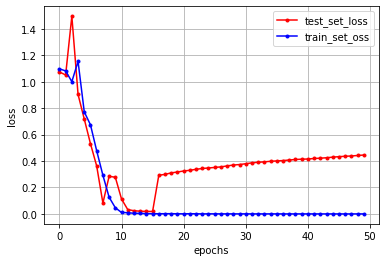

In [100]:
y_vloss = hist.history['val_loss']
y_loss = hist.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='test_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

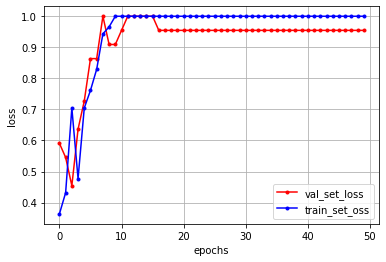

In [101]:
y_vloss = hist.history['val_accuracy']
y_loss = hist.history['accuracy']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

# 입력데이터

In [103]:
def word_predict(word,tok2):
    loaded_model = load_model('./model2/tt_16-0.0187.hdf5')
    word_input = [okt.morphs(word.replace(' ', ''), norm=True)]
    temp=[]
    for j in range(len(word_input)):
        for document in word_input[j]:
            temp.append(re.sub(r'[^ ㄱ-ㅣ가-힣A-Za-z]', '', document)) #특수기호 제거, 정규 표현식    
        word_input[j] = temp
        temp=[]
    stopwords = ['을', '를', '이', '가', '은', '는','이','그','있','n','nn','t','의','되','라','한','다','하','더','에','서','나',
            '과','고','며','와','지','해','도','지','못','안','않','로','들','된','것','에는','안녕',
            '반갑','내','등','할','자','있다','','직','군','위','식','각','출','창','시','수','및','신','영','화','살','여','양','송','대','데',
            '연','구','살','장','또','적','D','력','인','향','년','후','생','기','봐','문','니','사','본','제','작','관','일','분','야',
            '중','거','명','어','개','타','제','또는','요','전','몇','중','에서','있는데요','된다','또한','되','돼','않','으로','만','있습니다','하는','하는것이',
            '만','푹','지금','하는','곳',]
    
    token=[]
    for w in word_input:
        temp_X=[]
        temp_X =w
        temp_X = [t for t in temp_X if not t in stopwords]
        token.append(temp_X)
    print(token)
    max_word = 8000
    tok1 = tok2.texts_to_sequences(token)
    print(tok1)
    if not tok1:
        return print("다른 단어를 입력해주세요")
    max_len = 600
    sequences_matrix = sequence.pad_sequences(tok1, maxlen=max_len)
    print(ac_label[np.argmax(loaded_model.predict(sequences_matrix), axis=1)[0]])





In [104]:
ac_label=['game','mobile','web']

In [108]:
word_predict("모바일 안드로이드 아이폰 앱스토어 앱", tok)

[['모바일', '안드로이드', '아이폰', '앱스토어', '앱']]
[[11, 58, 186, 817, 5]]
mobile
